<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

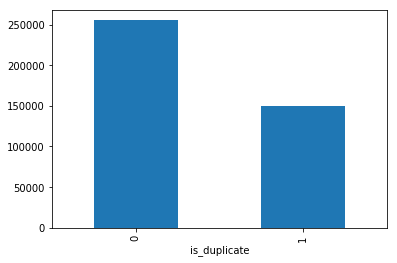

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [8]:
df['is_duplicate'].mean()

0.369197853026293

<h3> 3.2.2 Number of unique questions </h3>

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



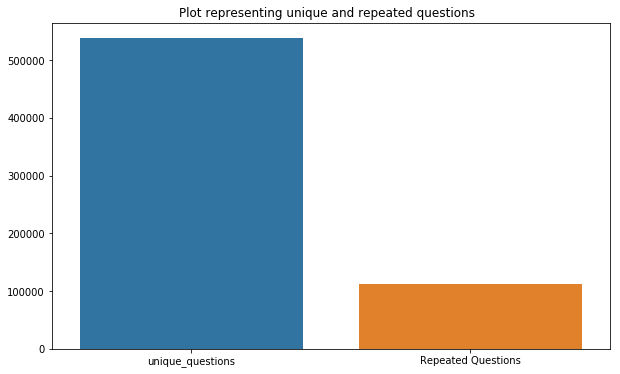

In [10]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

In [12]:
qids.head()

0    1
1    3
2    5
3    7
4    9
dtype: int64

Maximum number of times a single question is repeated: 157



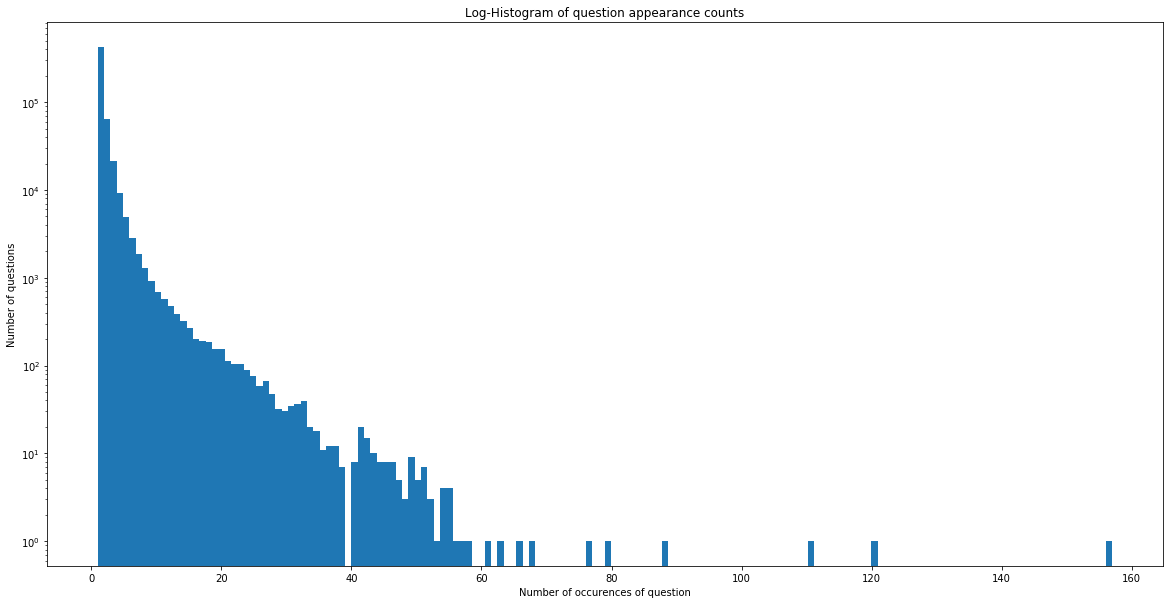

In [13]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [14]:
df[df.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [15]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [16]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [17]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [18]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

In [19]:
df[0:]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,1,1,19,62,4,11,0.0,14.0,0.000000,2,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,1,1,30,41,7,9,4.0,16.0,0.250000,2,0
8,8,17,18,When do you use ã· instead of ã?,"When do you use ""&"" instead of ""and""?",0,1,2,31,37,8,8,6.0,16.0,0.375000,3,1
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,1,1,60,49,9,9,3.0,18.0,0.166667,2,0


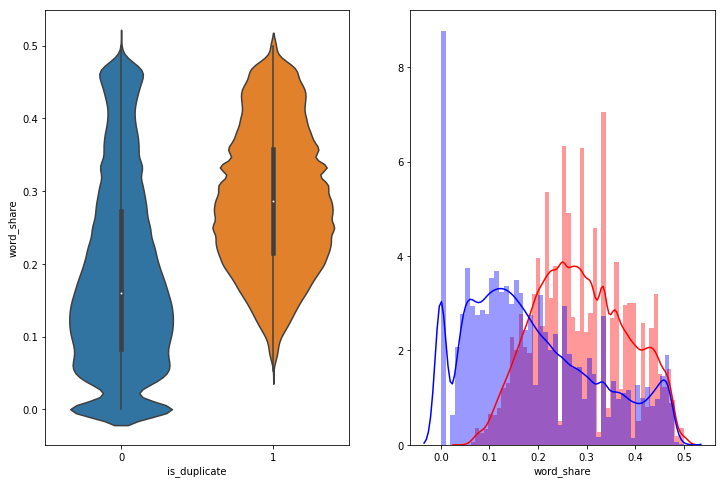

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

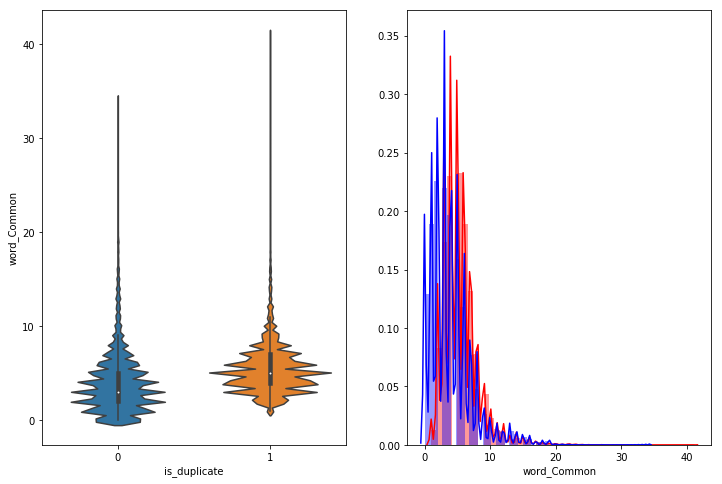

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

# 2nd Notebook:Quora_Preprocessing.ipynb

### 1.2.1 : EDA: Advanced Feature Extraction.

In [22]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import nltk
# nltk.download()

In [23]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [24]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [25]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [26]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [27]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [28]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding="utf-8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding="utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [29]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110303
Total number of words in non duplicate pair questions : 33194892


Word Cloud for Duplicate Question pairs


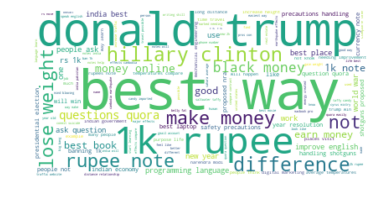

In [30]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


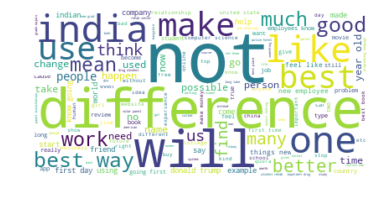

In [31]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

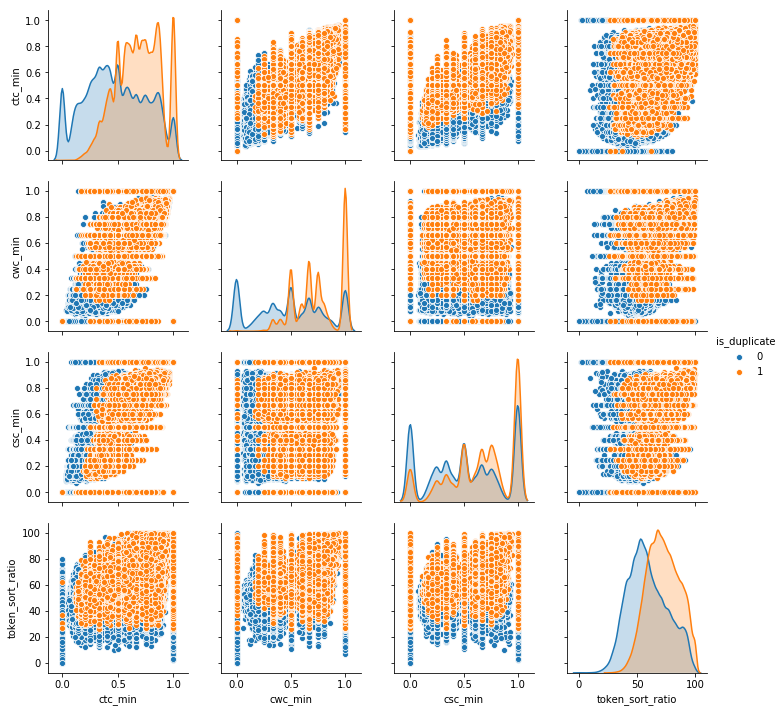

In [32]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

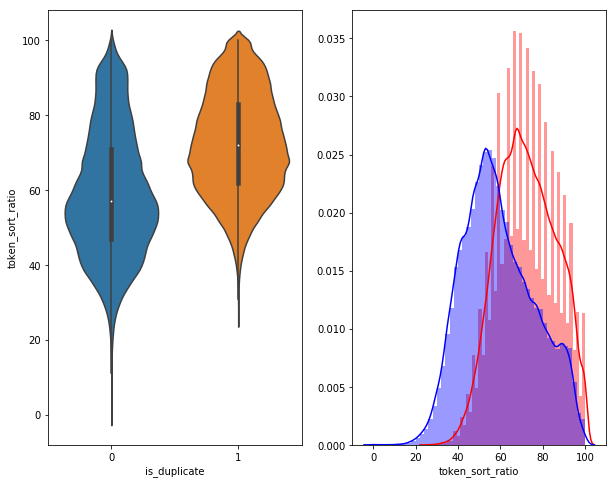

In [33]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

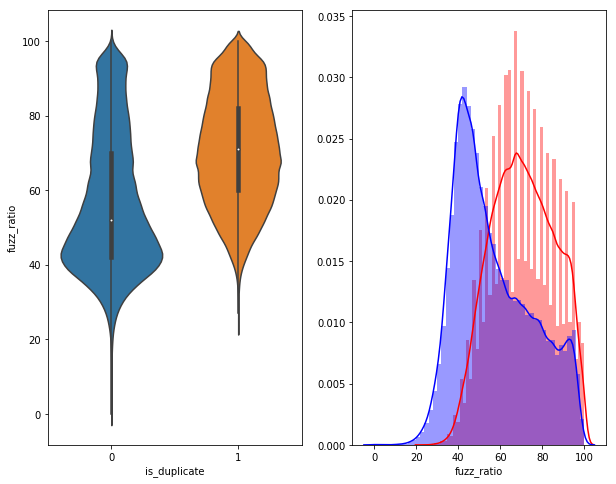

In [34]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [35]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [36]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.371s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.296s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 2.785s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 1.969s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 1.849s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 1.886s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

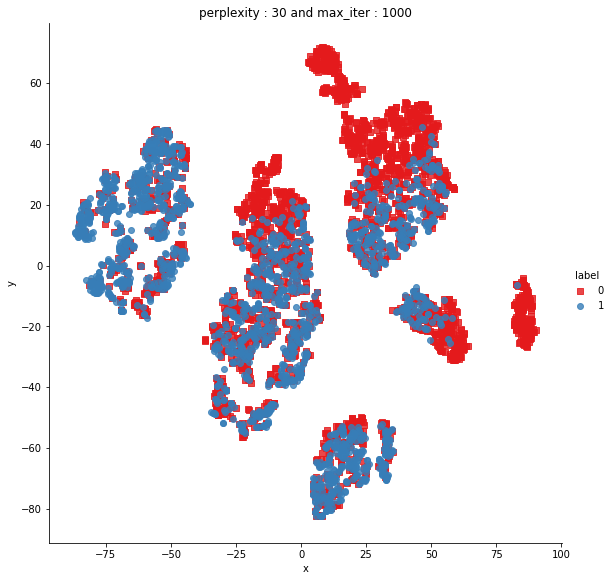

In [37]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [38]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.009s...
[t-SNE] Computed neighbors for 5000 samples in 0.361s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.217s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 9.078s)
[t-SNE] Iteration 100: error = 69.1100388, gradient norm = 0.0034323 (50 iterations in 5.171s)
[t-SNE] Iteration 150: error = 67.6163483, gradient norm = 0.0017810 (50 iterations in 4.635s)
[t-SNE] Iteration 200: error = 67.0578613, gradient norm = 0.0011246 (50 iterations in 4.552s)
[t-SNE] Iteration 250: error = 66.7297821, gradient norm = 0.0009272

In [39]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# 3rd NotebookQ_Mean_W2V.ipynb

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
from scipy.sparse import hstack
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm1

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
from sklearn.model_selection import train_test_split

In [41]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [42]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [43]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [44]:
dfnlp.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [45]:
df1  = dfnlp.merge(dfppro, on='id',how='left')

In [46]:
df1 = df1.drop(['qid1_x','qid2_x'],axis=1)
# df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [47]:
df1.shape

(404290, 35)

In [48]:
df4  = df1.merge(df3, on='id',how='left')

In [49]:
df4 = df4.sample(n=50000)

In [50]:
df4.shape

(50000, 35)

In [51]:
y_true = df4['is_duplicate_x']

In [52]:
y_true

157111    1
256127    0
275758    0
339967    0
293853    1
203160    1
221034    1
391435    1
122148    1
22932     0
135107    1
321550    1
390562    1
321641    0
221386    1
91708     1
140841    0
40380     0
168337    0
352779    1
174179    1
250050    1
28832     0
192799    1
61976     0
243373    1
178623    1
114748    1
351965    0
168599    1
         ..
347967    0
279093    0
340051    1
232581    1
220107    1
115954    1
23675     0
334251    0
173395    0
368775    0
286823    0
202282    0
110915    1
55110     0
134729    0
134633    1
378291    1
213499    0
386758    0
153304    1
224912    1
402646    0
103678    1
289407    0
110161    0
278486    1
338644    0
349720    0
252671    0
255335    1
Name: is_duplicate_x, Length: 50000, dtype: int64

In [53]:
df4 = df4.drop(['is_duplicate_x'],axis=1)

In [54]:
df4.shape

(50000, 34)

In [55]:
X_train,X_test, y_train, y_test = train_test_split(df4, y_true, stratify=y_true, test_size=0.3)

In [56]:
X_train.shape

(35000, 34)

In [57]:
X_test.shape

(15000, 34)

In [58]:
X_train.shape[0] + X_test.shape[0]

50000

In [59]:
# Filling the null values with ' '
X_train = X_train.fillna(' ')
nan_rows1 = X_train[X_train.isnull().any(1)]
print (nan_rows1)

# Filling the null values with ' '
X_test = X_test.fillna(' ')
nan_rows2 = X_test[X_test.isnull().any(1)]
print (nan_rows2)

Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]
Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]


## TFIDFW2V Vectorization on train data:

In [60]:
X_train['question1_x'].isnull().values.any()

False

In [61]:
X_train[X_train.isnull().any(1)]

,id,question1_x,question2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_train = list(X_train['question1_x']) + list(X_train['question2_x'])

tfidf_train = TfidfVectorizer(lowercase=False, )
tfidf_train.fit_transform(questions_train)

# # dict key:word and value:tf-idf score
word2tfidf_train = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [63]:
(X_train['question1_x'][12980:12995])

118211    what are some reviews of mpix film processing ...
187661    what will be the next step taken by modi to co...
286830    i am a third year civil engineering student  h...
375761    would hillary clinton be a good president for us 
778       for what use cases do you think deep learning ...
287448    how do i travel the world without spending my ...
184093               has india ever held a surgical strike 
109676           how can i participate in group discussion 
344099         which is the best wordpress security plugin 
100522           what are direct and inverse relationships 
268084    who supplied the san bernardino shooters with ...
10941     two cards were drawn without a replacement fro...
138356       how do i stop mucus from going down my throat 
255570    what would hapeen if there are no physical dis...
353098    as a supporter of bernie sanders  why should i...
Name: question1_x, dtype: object

In [64]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm1(list(X_train['question1_x'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)

In [65]:
vecs2 = []
for qu2 in tqdm1(list(X_train['question2_x'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

In [66]:
# # storing the final features to csv file
# if not os.path.isfile('X_train.csv'):
#     result1  = X_train
#     result1.to_csv('X_train.csv')
# # storing the final features to csv file
# if not os.path.isfile('y_train.csv'):
#     result2  = y_train
#     result2.to_csv('y_train.csv')

In [67]:
X_train_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
X_train_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)

In [68]:
X_train.drop(['q1_feats_m','q2_feats_m'],axis=1)

,id,question1_x,question2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
225515,225515,is there a long range wifi antenna that i can ...,what is the best omnidirectional wifi antenna ...,0.599988,0.428565,0.399992,0.181817,0.499995,0.249999,1.0,...,1,89,59,19,10,5.0,27.0,0.185185,3,1
378666,378666,what is the difference between tortional strai...,what are the differences between stress and st...,0.333322,0.249994,0.799984,0.799984,0.624992,0.499995,1.0,...,1,66,51,10,8,5.0,18.0,0.277778,3,1
250427,250427,what is an open circuit in electronics,why are resistors required in electronic circu...,0.000000,0.000000,0.333322,0.249994,0.142855,0.142855,0.0,...,1,39,50,7,7,1.0,14.0,0.071429,2,0
324317,324317,what is blogging and how can i start my own blog,how can we start our own blogs,0.499975,0.333322,0.599988,0.374995,0.571420,0.363633,0.0,...,3,49,31,11,7,4.0,18.0,0.222222,5,1
274675,274675,can i use a macbook pro charger for my macbook...,will charging a macbook pro using a macbook ai...,0.799984,0.499994,0.333322,0.199996,0.454541,0.384612,0.0,...,1,51,75,11,13,4.0,21.0,0.190476,2,0
184624,184624,what will be the effect of banning 500 and 1k ...,what will the real estate look like now after ...,0.571420,0.444440,0.666656,0.571420,0.571424,0.470585,0.0,...,9,83,72,17,14,7.0,29.0,0.241379,20,2
218728,218728,why has quora banned my real name account as f...,why does quora believe my name is fake,0.749981,0.499992,0.499988,0.499988,0.624992,0.499995,1.0,...,2,50,39,10,8,5.0,18.0,0.277778,5,1
121999,121999,what is the best source of news in india,what are the best sources of fmcg news in india,0.749981,0.599988,0.799984,0.799984,0.777769,0.699993,1.0,...,1,41,48,9,10,7.0,19.0,0.368421,3,1
110888,110888,can someone help me to find free online course...,what are some useful free online courses for a...,0.714276,0.624992,0.249994,0.199996,0.499996,0.499996,0.0,...,1,75,78,12,12,5.0,24.0,0.208333,2,0
69717,69717,can an aircraft carrier be sunk,can a modern aircraft carrier be sunk with mod...,0.999967,0.599988,0.666644,0.499988,0.833319,0.499995,0.0,...,1,32,56,6,10,4.0,15.0,0.266667,2,0


In [69]:
if (1):
    X_train_q1['id']=X_train['id']
    X_train_q2['id']=X_train['id']
    df1  = X_train_q1.merge(X_train_q2, on='id',how='left')
    X_train  = X_train.merge(df1, on='id',how='left')

In [70]:
# from scipy.sparse import hstack 
# X_tr = hstack((X_train,X_train_q1,X_train_q2)).tocsr() 
# print(X_tr.shape, y_train.shape) 
# print("="*100)

## TFIDFW2V Vectorization on test data:

In [71]:
X_test['question1_x'].isnull().values.any()

False

In [72]:
X_test[X_test.isnull().any(1)]

,id,question1_x,question2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions_test = list(X_test['question1_x']) + list(X_test['question2_x'])

# tfidf_train = TfidfVectorizer(lowercase=False, )
tfidf_train.transform(questions_test)

# # dict key:word and value:tf-idf score
word2tfidf_test = dict(zip(tfidf_train.get_feature_names(), tfidf_train.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [74]:
(X_test['question1_x'][12980:12995])

234700    how is the word  premonition  used in a sentence 
105349                        why is not my phone charging 
256855    how do you multiply some cells by a constant i...
160120    which course is better for civil engg student ...
244750    is it illegal to use a fake  edu email to get ...
216089                    how do i get over a good breakup 
171608    what are some of the best love proposal lines ...
78271     i am 17 now  how can i  earn  my first house o...
295483    what has been your most embarrassing moment fr...
349432    i have learnt nothing during my ca articleship...
244878    how would you compare ncat and mat exams and i...
203296    what are some ways i can make money as a 13 ye...
32907        what is the latest google update for seo 2016 
157379                   how could i start my own business 
353797                   what is this on my shoulder blade 
Name: question1_x, dtype: object

In [75]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm1(list(X_test['question1_x'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)

In [76]:
vecs2 = []
for qu2 in tqdm1(list(X_test['question2_x'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

In [77]:
# if not os.path.isfile('X_test.csv'):
#     result3  = X_test
#     result3.to_csv('X_test.csv')
# # storing the final features to csv file
# if not os.path.isfile('y_test.csv'):
#     result4  = y_test
#     result4.to_csv('y_test.csv')

In [78]:
X_test_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
X_test_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

In [79]:
X_test.drop(['q1_feats_m','q2_feats_m'],axis=1)

,id,question1_x,question2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
159393,159393,looking back what was the most important risk...,what is the most embarrassing music you have e...,0.249997,0.199998,0.714276,0.555549,0.466664,0.368419,0.0,...,1,89,112,15,18,5.0,33.0,0.151515,3,1
84324,84324,what are some good one line jokes,what are the best one line jokes,0.749981,0.749981,0.666644,0.666644,0.714276,0.714276,1.0,...,1,34,33,7,7,5.0,14.0,0.357143,2,0
261269,261269,what are the differences between a belgian mal...,what is the difference between a belgian malin...,0.799984,0.799984,0.833319,0.833319,0.749994,0.749994,1.0,...,1,74,71,12,11,8.0,21.0,0.380952,2,0
15668,15668,how do i make an android application using pyt...,how do i get started with android application ...,0.399992,0.399992,0.749981,0.749981,0.555549,0.555549,0.0,...,9,50,58,9,9,5.0,18.0,0.277778,10,8
171958,171958,what is the best ola hack for unlimited ola mo...,can you give me that coupon code by which i ca...,0.571420,0.333331,0.624992,0.333331,0.499997,0.290322,0.0,...,4,85,141,18,30,7.0,41.0,0.170732,8,0
354064,354064,is species singular or plural how do you sa...,how is the word crisis spelled in plural form,0.399992,0.285710,0.749981,0.428565,0.555549,0.333331,0.0,...,1,82,48,15,9,3.0,23.0,0.130435,2,0
258161,258161,if you had one extra time in a day what would ...,what would you do with extra time if one day i...,0.999980,0.714276,0.666656,0.571420,0.692302,0.692302,0.0,...,1,53,56,13,13,8.0,25.0,0.320000,2,0
83575,83575,will science answer why life came to be,is there anywhere that i can find the history ...,0.499988,0.181817,0.499988,0.199998,0.499994,0.181817,1.0,...,1,40,119,8,22,4.0,29.0,0.137931,3,1
278936,278936,does china have hard water if so what proble...,will china run out of water,0.666644,0.399992,0.000000,0.000000,0.333328,0.166665,0.0,...,2,63,28,12,6,2.0,18.0,0.111111,3,1
121078,121078,where do i find ca final law amendments for no...,what are the applicable amendments for nov 201...,0.714276,0.555549,0.249994,0.199996,0.545450,0.428568,0.0,...,3,53,81,11,14,5.0,25.0,0.200000,4,2


In [80]:
if (1):
    X_test_q1['id']=X_test['id']
    X_test_q2['id']=X_test['id']
    df2  = X_test_q1.merge(X_test_q2, on='id',how='left')
    X_test  = X_test.merge(df2, on='id',how='left')

In [81]:
X_train.shape

(35000, 228)

In [82]:
X_test.shape

(15000, 228)

## Storing final features and their targets with respective splitting

In [67]:
X_train.to_pickle("X_train.txt")
y_train.to_pickle("y_train.txt")
X_test.to_pickle("X_test.txt")
y_test.to_pickle("y_test.txt")

In [4]:
X_train = pd.read_pickle("X_train.txt")
y_train = pd.read_pickle("y_train.txt")
X_test = pd.read_pickle("X_test.txt")
y_test = pd.read_pickle("y_test.txt")

In [83]:
X_train = X_train.drop(['id','question1_x','question2_x','q1_feats_m','q2_feats_m','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],axis=1)
# X_train.drop(X_train.index[0], inplace=True)
X_test = X_test.drop(['id','question1_x','question2_x','q1_feats_m','q2_feats_m','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],axis=1)
# X_test.drop(X_test.index[0], inplace=True)

In [84]:
X_train

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.599988,0.428565,0.399992,0.181817,0.499995,0.249999,1.0,0.0,10.0,15.0,...,76.833180,-64.701943,74.552865,-17.591147,33.917316,54.252092,-90.961439,-56.079004,-72.596372,-22.015076
1,0.333322,0.249994,0.799984,0.799984,0.624992,0.499995,1.0,1.0,2.0,9.0,...,33.545532,-50.014668,93.353633,19.302470,15.820086,-6.613687,8.219727,58.742244,-48.440564,-12.296548
2,0.000000,0.000000,0.333322,0.249994,0.142855,0.142855,0.0,0.0,0.0,7.0,...,64.567960,69.991607,58.614401,-27.826696,-27.530198,36.903059,-44.146142,-31.922138,-25.231779,5.487270
3,0.499975,0.333322,0.599988,0.374995,0.571420,0.363633,0.0,0.0,4.0,9.0,...,28.266155,8.027344,-8.522524,14.211238,14.490109,37.120787,90.289765,-15.637051,39.606197,-36.689997
4,0.799984,0.499994,0.333322,0.199996,0.454541,0.384612,0.0,0.0,2.0,12.0,...,87.306036,-85.796291,133.902341,-180.280625,-45.102907,-19.438296,-57.070073,-67.693019,-91.220155,175.131476
5,0.571420,0.444440,0.666656,0.571420,0.571424,0.470585,0.0,1.0,3.0,15.5,...,108.851428,-101.651127,51.071270,54.356097,-9.679001,10.409853,-1.357479,18.961135,-49.037676,46.815770
6,0.749981,0.499992,0.499988,0.499988,0.624992,0.499995,1.0,1.0,2.0,9.0,...,22.043658,-10.636277,64.890679,10.187248,32.154488,-13.311645,39.785874,-4.864076,-68.319248,7.932451
7,0.749981,0.599988,0.799984,0.799984,0.777769,0.699993,1.0,1.0,1.0,9.5,...,16.828634,6.864732,76.218312,44.990899,-29.898956,31.927285,-85.603016,14.800289,8.564635,23.286515
8,0.714276,0.624992,0.249994,0.199996,0.499996,0.499996,0.0,0.0,0.0,12.0,...,102.161649,18.643393,29.068312,19.206329,16.630155,-4.253543,-132.352348,8.181464,-39.634710,-27.350008
9,0.999967,0.599988,0.666644,0.499988,0.833319,0.499995,0.0,1.0,4.0,8.0,...,46.810245,16.053178,169.330674,-66.539464,-32.530921,39.807243,-30.130974,-16.616328,-151.730252,78.154780


In [85]:
X_test

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.249997,0.199998,0.714276,0.555549,0.466664,0.368419,0.0,0.0,4.0,17.0,...,167.008300,-160.510764,30.686412,24.902986,-98.926838,74.098531,-72.298479,-45.710504,-26.442407,1.401694
1,0.749981,0.749981,0.666644,0.666644,0.714276,0.714276,1.0,1.0,0.0,7.0,...,9.908487,-35.613452,7.146711,-22.214779,-33.773450,-19.359207,-23.289286,-15.045848,6.595360,4.792436
2,0.799984,0.799984,0.833319,0.833319,0.749994,0.749994,1.0,1.0,0.0,12.0,...,48.551978,-8.913741,28.224619,-6.657474,-39.474457,61.421969,-45.531208,8.092509,-56.655060,39.753381
3,0.399992,0.399992,0.749981,0.749981,0.555549,0.555549,0.0,1.0,0.0,9.0,...,68.740551,-1.901869,104.772066,-22.270597,-15.836935,23.698562,7.301049,-17.519037,-70.676632,44.191657
4,0.571420,0.333331,0.624992,0.333331,0.499997,0.290322,0.0,0.0,13.0,24.5,...,265.597721,-20.069196,106.186986,99.737752,-81.338625,104.758339,83.542746,-54.386192,-157.936524,136.218288
5,0.399992,0.285710,0.749981,0.428565,0.555549,0.333331,0.0,0.0,6.0,12.0,...,147.477230,-60.102039,111.798863,-38.349041,-25.567802,-23.702409,-67.870252,-48.808083,-81.292278,132.234456
6,0.999980,0.714276,0.666656,0.571420,0.692302,0.692302,0.0,0.0,0.0,13.0,...,75.001106,-77.013168,41.067546,-17.521150,23.194849,-47.449661,67.060408,-54.189187,-110.671271,114.655695
7,0.499988,0.181817,0.499988,0.199998,0.499994,0.181817,1.0,0.0,14.0,15.0,...,112.528245,-120.727119,219.839622,-6.988652,-34.946253,-9.941513,-127.728199,79.466766,-88.366149,86.123412
8,0.666644,0.399992,0.000000,0.000000,0.333328,0.166665,0.0,0.0,6.0,9.0,...,15.666682,-27.890728,57.269831,51.908443,18.317918,28.616493,47.189571,7.799469,-49.730285,39.358114
9,0.714276,0.555549,0.249994,0.199996,0.545450,0.428568,0.0,0.0,3.0,12.5,...,50.088042,71.969918,71.579134,-67.095928,-11.120696,-40.330911,7.517987,108.507036,-50.912974,-19.619212


In [86]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_train.columns)
for i in cols:
#     data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [87]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_test.columns)
for i in cols:
#     data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

# 4th Notebook:ML_models.ipynb

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [89]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (35000, 218)
Number of data points in test data : (15000, 218)


In [90]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6284285714285714 Class 1:  0.37157142857142855
---------- Distribution of output variable in train data ----------
Class 0:  0.3715333333333333 Class 1:  0.3715333333333333


In [91]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8822391322845902


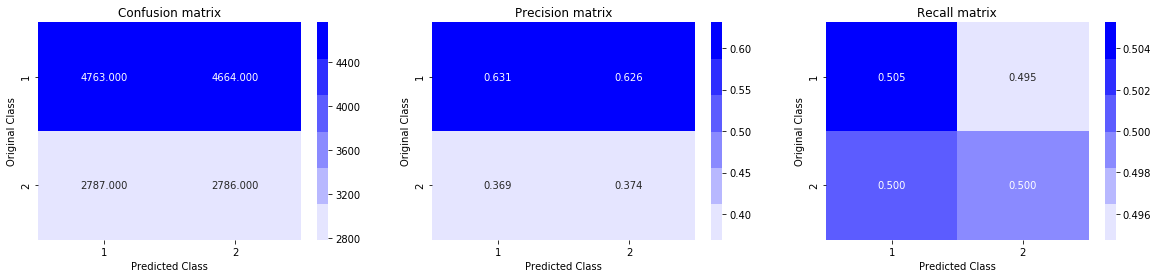

In [92]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [93]:
X_train.shape

(35000, 218)

In [94]:
y_train.shape

(35000,)

For values of alpha =  1e-05 The log loss is: 0.6139108254675448
For values of alpha =  0.0001 The log loss is: 0.5506413815858594
For values of alpha =  0.001 The log loss is: 0.5474480863407483
For values of alpha =  0.01 The log loss is: 0.5450587130323646
For values of alpha =  0.1 The log loss is: 0.545096165621808
For values of alpha =  1 The log loss is: 0.5429380505011125
For values of alpha =  10 The log loss is: 0.5348015870524657


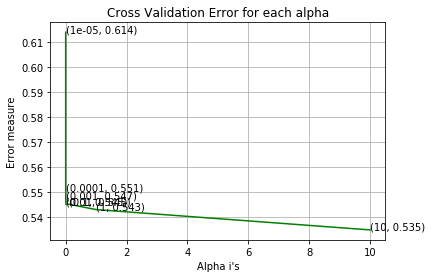

For values of best alpha =  10 The train log loss is: 0.5160872276182437
For values of best alpha =  10 The test log loss is: 0.5348015870524657
Total number of data points : 15000


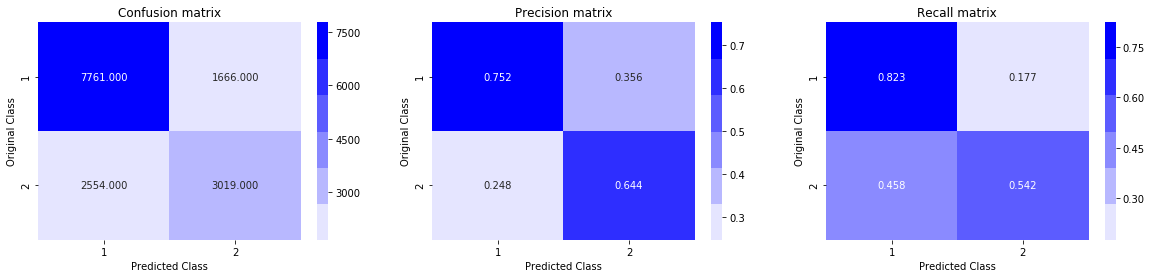

In [95]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6597667139263508
For values of alpha =  0.0001 The log loss is: 0.539880581781623
For values of alpha =  0.001 The log loss is: 0.5292727905290536
For values of alpha =  0.01 The log loss is: 0.5807879548496996
For values of alpha =  0.1 The log loss is: 0.6096658493336757
For values of alpha =  1 The log loss is: 0.6360273963693932
For values of alpha =  10 The log loss is: 0.6561313121658249


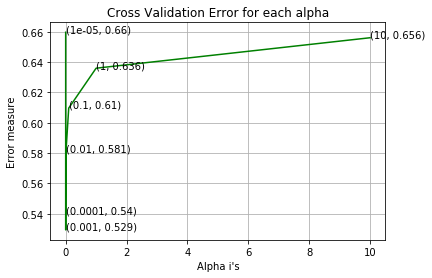

For values of best alpha =  0.001 The train log loss is: 0.5245241440419677
For values of best alpha =  0.001 The test log loss is: 0.5292727905290536
Total number of data points : 15000


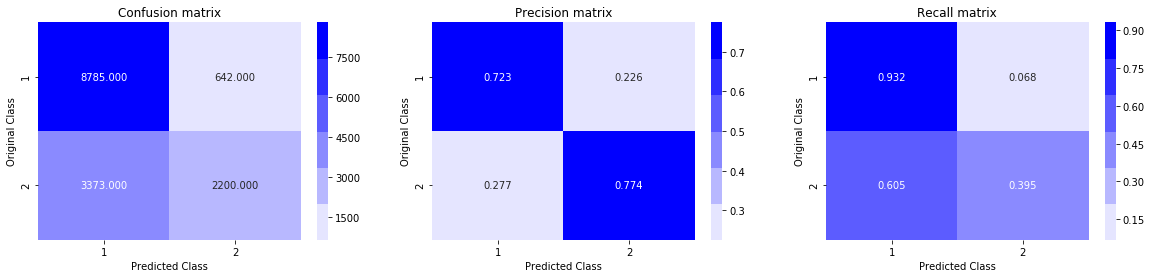

In [96]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [19]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684851	valid-logloss:0.684953
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.615672	valid-logloss:0.617235
[20]	train-logloss:0.564235	valid-logloss:0.566696
[30]	train-logloss:0.52571	valid-logloss:0.52901
[40]	train-logloss:0.496076	valid-logloss:0.49987
[50]	train-logloss:0.472854	valid-logloss:0.477215
[60]	train-logloss:0.454286	valid-logloss:0.459067
[70]	train-logloss:0.439118	valid-logloss:0.444304
[80]	train-logloss:0.42691	valid-logloss:0.432455
[90]	train-logloss:0.4169	valid-logloss:0.422847
[100]	train-logloss:0.408725	valid-logloss:0.414995
[110]	train-logloss:0.401912	valid-logloss:0.408567
[120]	train-logloss:0.396066	valid-logloss:0.403061
[130]	train-logloss:0.391374	valid-logloss:0.398884
[140]	train-logloss:0.38691	valid-logloss:0.394923
[150]	train-logloss:0.383345	valid-logloss:0.391835
[160]	train-logloss:0.380073	valid-

Total number of data points : 15000


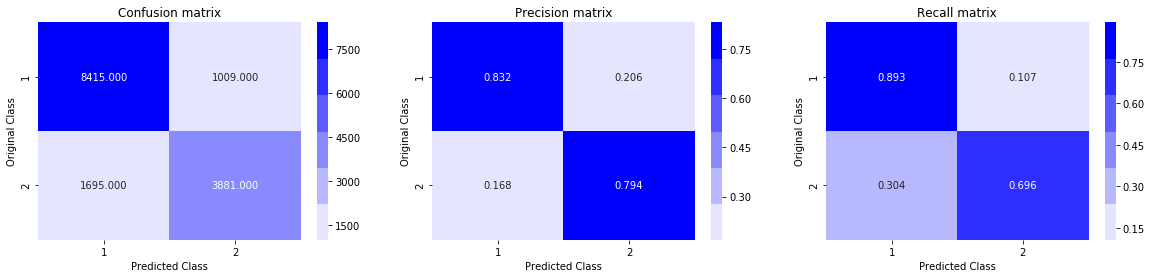

In [20]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

### 5.1 : Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.

In [11]:
df4  = df1.merge(df3, on='id',how='left')

In [12]:
df4 = df4.sample(n=50000)

In [13]:
df4.shape

(50000, 35)

In [14]:
y_true = df4['is_duplicate_x']

In [15]:
y_true

107040    0
165041    0
64671     0
371007    0
322766    0
         ..
306493    0
206537    1
225852    0
73709     1
269458    0
Name: is_duplicate_x, Length: 50000, dtype: int64

In [16]:
df4 = df4.drop(['is_duplicate_x'],axis=1)

In [17]:
df4.shape

(50000, 34)

In [18]:
X_train,X_test, y_train, y_test = train_test_split(df4, y_true, stratify=y_true, test_size=0.3)

In [19]:
X_train.shape

(35000, 34)

In [20]:
X_test.shape

(15000, 34)

In [21]:
X_train.shape[0] + X_test.shape[0]

50000

In [22]:
# Filling the null values with ' '
X_train = X_train.fillna(' ')
nan_rows1 = X_train[X_train.isnull().any(1)]
print (nan_rows1)

# Filling the null values with ' '
X_test = X_test.fillna(' ')
nan_rows2 = X_test[X_test.isnull().any(1)]
print (nan_rows2)

Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]
Empty DataFrame
Columns: [id, question1_x, question2_x, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, qid1_y, qid2_y, question1_y, question2_y, is_duplicate_y, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 34 columns]


In [23]:
X_train

,id,question1_x,question2_x,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
60596,60596,how do i insert a sigma symbol into a word doc...,how can i insert a line break in ms word,0.399992,0.399992,0.599988,0.599988,0.499995,0.454541,0.0,...,1,52,41,11,10,4.0,20.0,0.200000,3,1
383067,383067,how do i get a job as a film and tv critic,how does someone become a professional tv or f...,0.599988,0.499992,0.499988,0.333328,0.499995,0.416663,1.0,...,4,43,57,12,10,5.0,21.0,0.238095,9,1
293924,293924,how do i apply for a pan card online,how can i apply pan card with initial in surna...,0.749981,0.374995,0.599988,0.374995,0.666659,0.333331,0.0,...,6,37,89,9,18,6.0,26.0,0.230769,18,6
29120,29120,what is the meaning of a clean sheet in soccer,in soccer what does it mean when a club is in...,0.249994,0.249994,0.666656,0.571420,0.499995,0.416663,0.0,...,1,49,62,10,12,4.0,21.0,0.190476,2,0
67034,67034,why should i learn algebra,when will the em drive be disproved,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,6,27,36,5,7,0.0,12.0,0.000000,13,1
7714,7714,how do i advertise my business on quora,how do i advertise on quora,0.999950,0.666644,0.999975,0.799984,0.999983,0.749991,1.0,...,5,40,28,8,6,6.0,14.0,0.428571,11,1
131675,131675,how can you get fat from not eating,can you get fat from eating salad,0.999967,0.749981,0.999967,0.599988,0.857131,0.749991,0.0,...,1,36,34,8,7,5.0,15.0,0.333333,3,1
105411,105411,would you marry a non virgin woman,why would you marry a non virgin,0.999975,0.799984,0.999950,0.666644,0.857131,0.857131,0.0,...,6,35,33,6,6,4.0,12.0,0.333333,8,4
112404,112404,how to activate whatsapp on my new iphone with...,can we use same mobile number on two different...,0.444440,0.307690,0.399992,0.153845,0.428568,0.193548,1.0,...,1,77,149,14,30,6.0,42.0,0.142857,2,0
394409,394409,what is it like having an attractive spouse,why is it that other people own spouses appear...,0.333322,0.166664,0.399992,0.249997,0.374995,0.187499,0.0,...,1,43,83,7,14,2.0,21.0,0.095238,3,1


## Preparing train data matrix

### Tfidf vectorization on train data

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
questions_train = list(X_train['question1_x']) + list(X_train['question2_x'])
vectorizer_tfidf_ques = TfidfVectorizer(lowercase=False,min_df=10)
vectorizer_tfidf_ques.fit(questions_train)

q1_tfidf_train = vectorizer_tfidf_ques.transform(X_train['question1_x'])
q2_tfidf_train = vectorizer_tfidf_ques.transform(X_train['question2_x'])
print("Shape of matrix after q1_tfidf_train ",q1_tfidf_train.shape)
print("Shape of matrix after q2_tfidf_train ",q2_tfidf_train.shape)

Shape of matrix after q1_tfidf_train  (35000, 5197)
Shape of matrix after q2_tfidf_train  (35000, 5197)


In [25]:
X_train = X_train.drop(['id','question1_x','question2_x','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],axis=1)

In [26]:
X_train = hstack((X_train,q1_tfidf_train,q2_tfidf_train))

In [27]:
X_train

<35000x10420 sparse matrix of type '<class 'numpy.float64'>'
	with 1474407 stored elements in COOrdinate format>

## Preparing test data matrix

### Tfidf vectorization on test data

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

q1_tfidf_test = vectorizer_tfidf_ques.transform(X_test['question1_x'])
q2_tfidf_test = vectorizer_tfidf_ques.transform(X_test['question2_x'])
print("Shape of matrix after q1_tfidf_test ",q1_tfidf_test.shape)
print("Shape of matrix after q2_tfidf_test ",q2_tfidf_test.shape)

Shape of matrix after q1_tfidf_test  (15000, 5197)
Shape of matrix after q2_tfidf_test  (15000, 5197)


In [29]:
X_test = X_test.drop(['id','question1_x','question2_x','qid1_y','qid2_y','question1_y','question2_y','is_duplicate_y'],axis=1)

In [30]:
X_test = hstack((X_test,q1_tfidf_test,q2_tfidf_test))

In [31]:
X_test

<15000x10420 sparse matrix of type '<class 'numpy.float64'>'
	with 630327 stored elements in COOrdinate format>

<h2> Logistic Regression with hyperparameter tuning </h2>

In [64]:
X_train.shape

(35000, 10476)

In [65]:
y_train.shape

(35000,)

For values of alpha =  1e-05 The log loss is: 0.4348345550728513
For values of alpha =  0.0001 The log loss is: 0.42239048766503967
For values of alpha =  0.001 The log loss is: 0.43395388114416994
For values of alpha =  0.01 The log loss is: 0.4522644937425442
For values of alpha =  0.1 The log loss is: 0.462661133296654
For values of alpha =  1 The log loss is: 0.49279458859004877
For values of alpha =  10 The log loss is: 0.5494454892556244


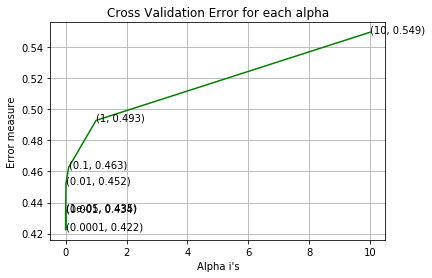

For values of best alpha =  0.0001 The train log loss is: 0.41862086549062827
For values of best alpha =  0.0001 The test log loss is: 0.42239048766503967
Total number of data points : 15000


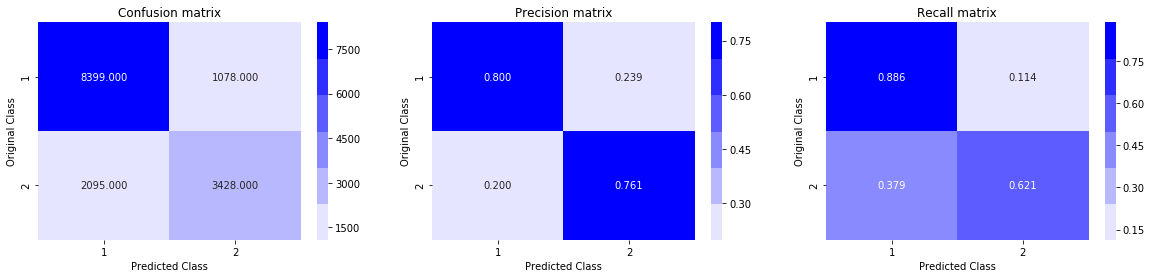

In [48]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.45672268969407215
For values of alpha =  0.0001 The log loss is: 0.4676851980307176
For values of alpha =  0.001 The log loss is: 0.4828686012238199
For values of alpha =  0.01 The log loss is: 0.49771951744742765
For values of alpha =  0.1 The log loss is: 0.5287577129629455
For values of alpha =  1 The log loss is: 0.5702303405814794
For values of alpha =  10 The log loss is: 0.5824917994428067


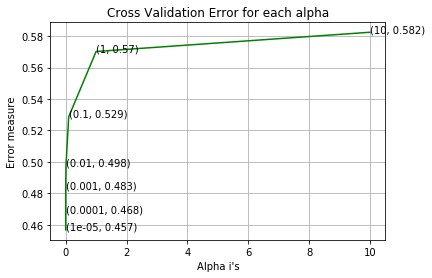

For values of best alpha =  1e-05 The train log loss is: 0.46144952981653664
For values of best alpha =  1e-05 The test log loss is: 0.45672268969407215
Total number of data points : 15000


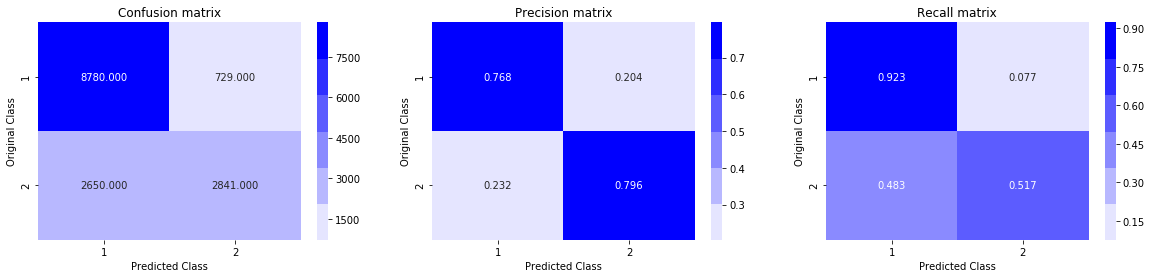

In [67]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [49]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
params = {      
    'max_depth': [3, 4, 5, 6, 7, 8],       
    'eta' : [0.01, 0.02, 0.05, 0.1]   
}

xgb = xgb.XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='neg_log_loss', n_jobs=-1, verbose=10, random_state=42 ,return_train_score=True) 
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   17.1s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   25.6s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   31.7s remaining:   54.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   36.0s remaining:   36.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   37.2s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   39.6s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   49.1s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   59.9s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
     

In [50]:
print('Best hyperparameters:')
print(random_search.best_params_)

Best hyperparameters:
{'eta': 0.02, 'max_depth': 8}


In [56]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 8

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.683136	valid-logloss:0.683294
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.600507	valid-logloss:0.602926
[20]	train-logloss:0.540315	valid-logloss:0.54569
[30]	train-logloss:0.495154	valid-logloss:0.503447
[40]	train-logloss:0.460269	valid-logloss:0.471273
[50]	train-logloss:0.432758	valid-logloss:0.446433
[60]	train-logloss:0.410453	valid-logloss:0.426939
[70]	train-logloss:0.392581	valid-logloss:0.411771
[80]	train-logloss:0.377723	valid-logloss:0.399318
[90]	train-logloss:0.365933	valid-logloss:0.389516
[100]	train-logloss:0.3559	valid-logloss:0.381551
[110]	train-logloss:0.347084	valid-logloss:0.375032
[120]	train-logloss:0.339534	valid-logloss:0.369721
[130]	train-logloss:0.333442	valid-logloss:0.365377
[140]	train-logloss:0.328079	valid-logloss:0.361857
[150]	train-logloss:0.32329	valid-logloss:0.358693
[160]	train-logloss:0.319361	val

In [58]:
print("The test log loss is:",log_loss(y_test, predict_y, labels=random_search.classes_, eps=1e-15))

The test log loss is: 0.33988687149450025


Total number of data points : 15000


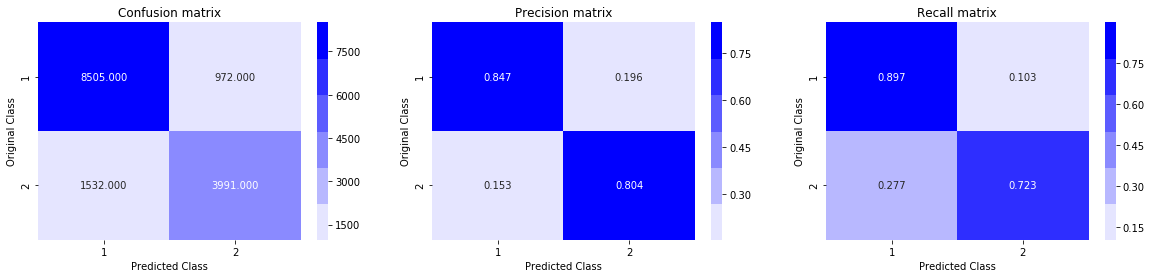

In [60]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [2]:
from prettytable import PrettyTable
x = PrettyTable() 
x.field_names = ["Vectorizer", "Model", "Test log loss"] 
x.add_row(["TFIDF", "Random Model", 0.88]) 
x.add_row(["TFIDF", "Logistic Regression", 0.42])
x.add_row(["TFIDF", "Linear SVM", 0.45]) 
x.add_row(["TFIDF", "XGBoost", 0.33])
print(x)


+------------+---------------------+---------------+
| Vectorizer |        Model        | Test log loss |
+------------+---------------------+---------------+
|   TFIDF    |     Random Model    |      0.88     |
|   TFIDF    | Logistic Regression |      0.42     |
|   TFIDF    |      Linear SVM     |      0.45     |
|   TFIDF    |       XGBoost       |      0.33     |
+------------+---------------------+---------------+


# Procedure to solve this Case Study:

1. First I have checked the distribution of class 0 and class 1 points in the whole dataset , found out to be 63.08% of the points belong to class 0 and 36.92% belong to class 1 
2. Next i plotted the graph regarding number of unique questions and Repeated questions, found out that no. of unique questions are more than 5L, and no. of repeated questions are about 1L. 
3. Then I created some new basic features like: 
    a. freq_qid1 = Frequency of qid1's 
    b.  freq_qid2 = Frequency of qid2's 
    c.  q1len = Length of q1  
    d. q2len = Length of q2  
    e. q1_n_words = Number of words in Question 1 
    f.  q2_n_words = Number of words in Question 2  
    g. word_Common = (Number of common unique words in Question 1 and Question 2)  
    h. word_Total =(Total num of words in Question 1 + Total num of words in Question 2)  
    i. word_share = (word_common)/(word_Total) 
    j.  freq_q1+freq_q2 = sum total of frequency of qid1 and qid2 
    k.  freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2 
4. The distributions for word_share have some overlap on the  right-hand side, i.e., there are quite a lot of questions with high word similarity  
5. The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate 
6. Then I have done some basic preprocessing like: 
    a. Removing html tags  
    b. Removing Punctuations  
    c. Performing stemming 
    d.  Removing Stopwords  
    e. Expanding contractions. 
7. Apart from basic features as discussed in point 3, I have also extracted some advanced features i.e NL and Fuzzy Features like: 
    a. cwc_min 
    b. cwc_max 
    c. csc_min 
    d. csc_max 
    e. ctc_min 
    f. ctc_max 
    g. last_word_eq 
    h. first_word_eq 
    i. abs_len_diff 
    j. mean_len 
    k. fuzz_ratio 
    l. fuzz_partial_ratio 
    m. token_sort_ratio 
    n. token_set_ratio 
    o. longest_substr_ratio 
8. Then I combined all the additional features which are formed from point 3,7 and merged with original dataframe and randomly sampled 50k points 
9. Then splitted the data to X_train, X_test where 70% belong to X_train and 30% belong to X_test 
10. Checked for nan values and filled with white space, due to issues in tfidf vectorization 
11. Then I did TFIDFW2V vectorization on question1 and question 2 on both X_train and X_test and added these features to X_train and X_test respectively 
12. Dropped the redundant columns 
13. First I build a random model which gives  Log-loss = 0.88 , and for TFIDFW2W vectorized features on Test data for:
    a. Logistic regression = 0.53 
    b. Linear SVM = 0.52
    c. XGBoost = 0.36 

Assignment: 
1. Instead of TFIDFW2V, I tried only on TFIDF vectorization , where I got Log-loss for :
    a. Logistic Regression = 0.42, 
    b. Linear SVM = 0.45
    c. For XGBoost = 0.33